# Fidanet code for modelling colrad
This notebook has the code that was used to attempt creating a neural network to replace colrad in some aspects and detail some of the problems it had.

In [ ]:
%pylab inlab
from fidanet import *

In [ ]:
import h5py
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
import keras.callbacks

The following functions are used to call the fortran code for colrad and return the correct data. At this time, they specifically use starting states where n=1 has 1e10, and n>1 has 0, and the time dt = 1s for all. This is to model the steady state conditions.

In [ ]:
# Just for adding one set of inputs and outputs using inputs taken from
#  uniform distribution. This uses the same original states and dt = 1s for all.
#  Range variables:
#     ebr --> beam energy
#     Ter --> electron temp
#     Tir --> ion temp
#     dener --> electron density
#     Zeffr --> effective Z from impurities

def add_test(ebr = [1e-3,100.], Ter = [1e-3,20.], Tir = [1e-3,20.],
             dener = [1.0e12,2.0e14], Zeffr = [1.,fidanet.impq]):
    """
    Range variables ([float,float]): see above
    """
    eb = np.random.uniform(ebr[0],ebr[1])
    Te = np.random.uniform(Ter[0],Ter[1])
    Ti = np.random.uniform(Tir[0],Tir[1])
    dene = np.random.uniform(dener[0],dener[1])
    Zeff = np.random.uniform(Zeffr[0],Zeffr[1])
    
    denp, denimp = fidanet.getdens(dene,fidanet.impq,Zeff)
    
    fidanet.setplasma(dene,denp,denimp,Te,Ti)
    fidanet.setstates(np.array([1.0e10,0,0,0,0,0]),fidanet.states)
    fidanet.testcol(1,eb,1.0,fidanet.states,fidanet.dens)

    return np.array([eb,Te,Ti,dene,denp,denimp]), fidanet.dens.copy()


# Loops through the single version
def add_tests(num = 1, ebr = [1e-3,100.], Ter = [1e-3,20.], Tir = [1e-3,20.],
             dener = [1.0e12,2.0e14], Zeffr = [1.,fidanet.impq]):
    """
    num (int): number of data sets to generate
    Range variables ([float,float]): see above
    """
    inputs, outputs  = np.empty((num,6)), np.empty((num,6))
    for i in range(num):
        data = add_test(ebr,Ter,Tir,dener,Zeffr)
        inputs[i] = data[0]
        outputs[i] = data[1]
    return inputs, outputs


# Uses uniform distribution over log space
def add_log_test(ebr = [1e-3,100.], Ter = [1e-3,20.], Tir = [1e-3,20.],
             dener = [1.0e12,2.0e14], Zeffr = [1.,fidanet.impq]):
    """
    Range variables ([float,float]): see above
    """
    eb = np.random.uniform(np.log(ebr[0]),np.log(ebr[1]))
    Te = np.random.uniform(np.log(Ter[0]),np.log(Ter[1]))
    Ti = np.random.uniform(np.log(Tir[0]),np.log(Tir[1]))
    dene = np.random.uniform(np.log(dener[0]),np.log(dener[1]))
    
    eb = np.exp(eb)
    Te = np.exp(Te)
    Ti = np.exp(Ti)
    Zeff = np.random.uniform(Zeffr[0],Zeffr[1])
    
    denp, denimp = fidanet.getdens(dene,fidanet.impq,Zeff)
    
    fidanet.setplasma(dene,denp,denimp,Te,Ti)
    fidanet.setstates(np.array([1.0e10,0,0,0,0,0]),fidanet.states)
    fidanet.testcol(1,eb,1.0,fidanet.states,fidanet.dens)
    
    return np.array([eb,Te,Ti,dene,denp,denimp]), fidanet.dens.copy()


#More looping
def add_log_tests(num = 1, ebr = [1e-3,100.], Ter = [1e-3,20.],
                  Tir = [1e-3,20.], dener = [1.0e12,2.0e14],
                  Zeffr = [1.,fidanet.impq]):
    """
    num (int): number of data sets to generate
    Range variables ([float,float]): see above
    """
    inputs, outputs  = np.empty((num,6)), np.empty((num,6))
    for i in range(num):
        data = add_log_test(ebr,Ter,Tir,dener,Zeffr)
        inputs[i] = data[0]
        outputs[i] = data[1]
    return inputs, outputs

On occasion, I would find one of the outputs for a given input would be zero. In this case, I would set that zero to be half of the minimum value that other inputs had given for that output. This was to avoid infinite errors, as well as since the zero would simply be from numerical errors.

The following function is for saving data to a file. The two sets of code that follow are useful for adding supplemental data or opening a file.

In [ ]:
## Generates hdf5 file with input and output data
def save_data(inputs, outputs, file_address):
    """
    inputs (np.array): input data for colrad
    outputs (np.array): output data from colrad
    file_address (str): adddress for hdf5 file to work with
    """
    f = h5py.File(file_address)
    f.create_dataset('inputs', data = inputs)
    f.create_dataset('outputs', data = outputs)
    f.close()

In [ ]:
## Adds another dataset to an hdf5 file
def add2file(name, data, file_address):
    """
    name (str): name to give data set
    data (np.array): actual data to be saved
    file_address (str): adddress for hdf5 file to work with
    """
    f = h5py.File(file_address)
    f.create_dataset(name, data = data)
    f.close()

In [ ]:
def open_file(data_names, file_address):
    """
    data_names ([str]): names of datasets in file to be accessed
    file_address (str): adddress for hdf5 file to work with
    """
    f = h5py.File(file_address)
    data = tuple(f[name].value for name in data_names)
    f.close()
    return data

The following can be used to generate mean and standard deviation data for each column in an array. This can be used for both inputs and outputs.

In [ ]:
## Generates statistics on an array
def gen_stats(data, p):
    """
    p is the fraction used for making the model
        p + validation_split = 1
    """
    n =  int(len(data) * p)
    stats = np.array([np.mean(data[:n], axis=0),
                      np.std(data[:n], axis=0)])
    return stats

In [ ]:
##### For making fractional densities
def fracout(data):
    """
    data (np.array): outputs to be normalized to fractional outputs.
    """
    return np.transpose(np.transpose(data) / np.sum(data, axis = 1))

## Model creation

The following model never worked as well as it needed to, but the code is here for a way to see how it is layed out.

In [ ]:
##### Creates a model
model = Sequential()
model.add(Dense(256,input_dim = 6)) #6 for size of inputs
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('tanh'))
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dense(6)) # final output must be same size as actual output
model.compile(optimizer = Adam(), loss = 'mean_absolute_percentage_error',
              metrics = ['accuracy'])

Prior to training, normalize the inputs and outputs. The following is what I did:
```
inputs = (inputs - statin[0]) / statin[1]
outputs = (outputs) / statout[1]
```
where the stat variables were generated by the `gen_stats` function.
The outputs can be translated first to have a mean of zero, but I avoided that. I hoped that not changing the mean would make the network more likely to avoid returning any values that would be negative once shifted back into place.

In [ ]:
##Model training
model.fit(inputs,outputs,batch_size=256,epochs=20,
          callbacks=[keras.callbacks.EarlyStopping(monitor='loss',min_delta=1e-6,patience=5)],
          validation_split=0.3,verbose=1)

For saving a model to a file, or getting a model from a file

In [ ]:
model.save('model.h5')

In [ ]:
model = load_model('model.h5')

Here is the end of the code. while this worked to get an average error of a few percent, the maximum errors were massive. There seemed to be some patterns in the errors, where some areas of the input space seemed to have larger areas (can be seen below), but there weren't any areas that had no errors.

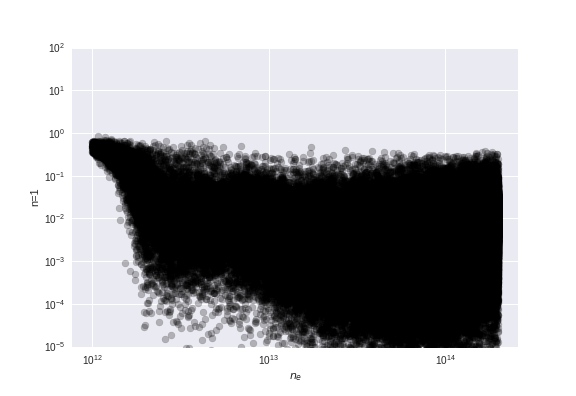

Above: percentage error in n=1 neutral density vs input electron density. Lower electron densities have higher average errors, but higher electron densities still have a large number of occasions of large error. At best, it looks like energy densities around 1e13 have a error that don't go above about 50%, but this is still way too high.
Below: percentage error in n=2 neutral density vs input electron temperature. Once again, lower temperatures lead to higher errors, and higher temperatures still have a large number of occurances of errors greater than 10%.

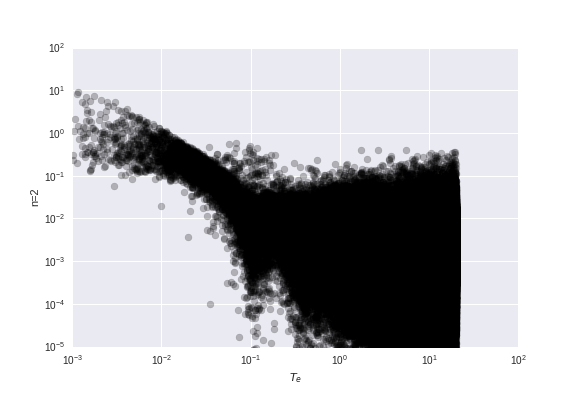

I suspect that there are a number of issues with my attempt to model the colrad function. Here are some of the things I think may have had a significant effect on the problem (though they may not be correct, and there may well be other contributing factors):
 - The form of the model: between the number of hidden nodes, activation functions, and the optimizer, I was simply guessing what to do. I expect that as is, this model structure doesn't work well for this data.
 - The data sets: Clearly there were parts of the input space that weren't as well modelled as others. Whether adding data points, or using more generated from the logarithmic uniform set, something is needed to better capture those areas.